- https://pytorch.org/vision/stable/models.html
- https://discuss.pytorch.org/t/how-to-delete-layer-in-pretrained-model/17648/2?u=yang-zhang

In [93]:
!nvidia-smi

Fri Apr  9 01:45:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   40C    P0    39W / 300W |   2902MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# params

In [94]:
HOME = "/data/git/shopee-product-matching"
pcomp = f'{HOME}/input/shopee-product-matching'

IMGSZ = 224
NWKRS = 8
BS = 32

import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
PIN_MEMORY = True if DEVICE == torch.device("cuda") else False

# code

In [95]:
import matplotlib.pyplot as plt

## utils

In [96]:
import numpy as np

def getf1(x, y):
    n = len(np.intersect1d(x, y))
    return 2 * n / (len(x) + len(y))


def getf1s(xs, ys):
    return (getf1(x, y) for x, y in zip(xs, ys))


def meanf1(xs, ys):
    return np.mean(list(getf1s(xs, ys)))


def get_targets(df):
    grp2ids = df.groupby("label_group").posting_id.agg("unique").to_dict()
    targets = df.label_group.map(grp2ids).values
    return targets

def preds2pids(preds, pids):
    return [pids[o] for o in preds]


def comb_preds(*preds):
    return (np.unique(np.concatenate(l)) for l in zip(*preds))


## vision

In [97]:
import pandas as pd
import torchvision
import torch
from torch import nn
from efficientnet_pytorch import EfficientNet
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, TensorDataset, DataLoader
from tqdm import tqdm


class VDataset(Dataset):
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.filepath[idx]
        img = Image.open(img_path)
        img = self.transforms(img)
        return img
    
# https://github.com/lukemelas/EfficientNet-PyTorch
tfms = transforms.Compose(
    [
        transforms.Resize((IMGSZ, IMGSZ)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


def mk_dl(df):
    ds = VDataset(df, tfms)
    dl = DataLoader(
        dataset=ds,
        batch_size=BS,
        num_workers=NWKRS,
        pin_memory=PIN_MEMORY,
        shuffle=False,
    )
    return dl

# https://discuss.pytorch.org/t/how-to-delete-layer-in-pretrained-model/17648/2?u=yang-zhang
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


def mk_embedder(mdl):
    if isinstance(mdl, torchvision.models.resnet.ResNet):
        mdl.fc = Identity()
    if isinstance(mdl, EfficientNet):
        def extract_feats(input_):
            return mdl.extract_features(input_).mean(dim=(-1, -2))
        mdl.forward = extract_feats
    return mdl


def mk_feats(dl, mdl):
    device = torch.device(DEVICE)
    mdl = mdl.to(device)
    mdl.eval()
    lst = []
    for dat in tqdm(dl, total=len(dl)):
        with torch.no_grad():
            fts = mdl(dat.to(device))
        lst.append(fts.cpu().detach().numpy())
    feats = np.concatenate(lst)
    return feats

## neighbor

In [133]:
from cuml.neighbors import NearestNeighbors
import numpy as np

N_NBRS = 50
CHUNK = 1024 * 4


def mk_nnmdl(feats, n_nbrs=N_NBRS):
    nnmdl = NearestNeighbors(N_NBRS, metric="cosine")
    nnmdl.fit(feats)
    return nnmdl


def get_nbrs_from_nnmdl(feats, nnmdl, sz_chunk=CHUNK):
    n = len(feats)
    n_nbrs = nnmdl.n_neighbors
    dists = np.zeros((n, n_nbrs), dtype="float")
    idx = np.zeros((n, n_nbrs), dtype="int")
    n_chunks = len(feats) // sz_chunk
    if len(feats) % sz_chunk != 0:
        n_chunks += 1
    for j in tqdm(range(n_chunks)):
        a = j * sz_chunk
        b = (j + 1) * sz_chunk
        b = min(b, len(feats))
        dists_, idx_ = nnmdl.kneighbors(
            feats[
                a:b,
            ]
        )
        dists[a:b] = dists_
        idx[a:b] = idx_
    return dists, idx


def get_nbrs(feats, n_nbrs=N_NBRS, sz_chunk=CHUNK):
    nnmdl = mk_nnmdl(feats, n_nbrs)
    dists, idx = get_nbrs_from_nnmdl(feats, nnmdl, sz_chunk)
    return dists, idx


def get_preds_by_thrsh(dists, idx, thrsh):
    preds = (ind[dst < thrsh] for dst, ind in zip(dists, idx))
    return preds


def find_best(dists, idx, pids, targets, thrshes=np.linspace(0.,1.,num=21)):
    f1_lst = []
    preds_lst = []
    for thrsh in tqdm(thrshes):
        preds = get_preds_by_thrsh(dists, idx, thrsh)
        preds = preds2pids(preds, pids)
        preds_lst.append(preds)
        f1 = meanf1(preds,targets)
        f1_lst.append(f1)
    f1_best, thrsh_best, preds_best = sorted(zip(f1_lst, thrshes, preds_lst), reverse=True)[0]
    res = {'f1_best': f1_best, 
           'thrsh_best': thrsh_best, 
           'preds_best': preds_best, 
           'thrshes': thrshes, 
           'f1_lst': f1_lst}
    return res

# run

In [99]:
df = pd.read_csv(f'{pcomp}/train.csv')
df['filepath'] = f"{pcomp}/train_images/"+df.image
pids = df.posting_id.values
targets = get_targets(df)

dl = mk_dl(df)

In [100]:
df.shape

(34250, 6)

In [101]:
df.head()

,posting_id,image,image_phash,title,label_group,filepath
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,/data/git/shopee-product-matching/input/shopee...
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,/data/git/shopee-product-matching/input/shopee...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,/data/git/shopee-product-matching/input/shopee...
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,/data/git/shopee-product-matching/input/shopee...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,/data/git/shopee-product-matching/input/shopee...


In [102]:
nm2mdl = {
#     'resnet18': torchvision.models.resnet18(pretrained=True),
#     'resnet34': torchvision.models.resnet34(pretrained=True),
#     'resnet50': torchvision.models.resnet50(pretrained=True),
#     'resnet101': torchvision.models.resnet101(pretrained=True),
#     'resnet152': torchvision.models.resnet152(pretrained=True),
#     'resnext50_32x4d': torchvision.models.resnext50_32x4d(pretrained=True),
#     'resnext101_32x8d': torchvision.models.resnext101_32x8d(pretrained=True),
    "efficientnet-b0": EfficientNet.from_pretrained("efficientnet-b0"),
#     "efficientnet-b1": EfficientNet.from_pretrained("efficientnet-b1"),
#     "efficientnet-b2": EfficientNet.from_pretrained("efficientnet-b2"),
#     "efficientnet-b3": EfficientNet.from_pretrained("efficientnet-b3"),
#     "efficientnet-b4": EfficientNet.from_pretrained("efficientnet-b4"),
#     "efficientnet-b5": EfficientNet.from_pretrained("efficientnet-b5"),
#     "efficientnet-b6": EfficientNet.from_pretrained("efficientnet-b6"),
#     "efficientnet-b7": EfficientNet.from_pretrained("efficientnet-b7"),
}

Loaded pretrained weights for efficientnet-b0


In [57]:
for dat in dl:
    dat 
    break

for nm,mdl in nm2mdl.items():
    mdl = mk_embedder(mdl)
    output = mdl(dat)
    print(nm, output.shape[1])

efficientnet-b0 1280


In [58]:
nm2feats = {nm: mk_feats(dl, mdl) for nm,mdl in nm2mdl.items()}

100%|██████████| 1071/1071 [01:57<00:00,  9.15it/s]


In [103]:
nm = "efficientnet-b0"
feats = nm2feats[nm]

In [104]:
type(feats)

numpy.ndarray

In [142]:
n = len(df)
print(n)
ms = [int(n*o) for o in np.linspace(0.2, 1., 5)]
# ms = [1000]
print(ms)

34250
[6850, 13700, 20550, 27400, 34250]


In [143]:
np.random.seed(101)
m2idx = {m: sorted(np.random.choice(range(n), m, replace=False)) for m in ms}
m2feats = {m:feats[idx] for m,idx in m2idx.items()}
m2targets = {m:targets[idx] for m,idx in m2idx.items()}
m2pids = {m:pids[idx] for m,idx in m2idx.items()}

In [144]:
{m:len(o) for m,o in m2idx.items()}

{6850: 6850, 13700: 13700, 20550: 20550, 27400: 27400, 34250: 34250}

In [145]:
{m:len(o) for m,o in m2feats.items()}

{6850: 6850, 13700: 13700, 20550: 20550, 27400: 27400, 34250: 34250}

In [146]:
{m:len(o) for m,o in m2targets.items()}

{6850: 6850, 13700: 13700, 20550: 20550, 27400: 27400, 34250: 34250}

In [147]:
m2nbrs = {m: get_nbrs(o) for m,o in m2feats.items()}

100%|██████████| 9/9 [00:02<00:00,  4.09it/s]


In [148]:
m2res = {m:find_best(*nbrs, m2pids[m], m2targets[m]) for m,nbrs in m2nbrs.items() }

100%|██████████| 21/21 [00:36<00:00,  1.74s/it]


In [149]:
m2f1 = {m:res['f1_best'] for m,res in m2res.items()}
m2f1

{6850: 0.5069895741281901,
 13700: 0.5524854976430211,
 20550: 0.5967969568778682,
 27400: 0.6314309264158013,
 34250: 0.6653714491688286}

In [154]:
m2thrsh = {m:res['thrsh_best'] for m,res in m2res.items()}

m2thrsh

{6850: 0.15000000000000002, 13700: 0.2, 20550: 0.2, 27400: 0.2, 34250: 0.2}

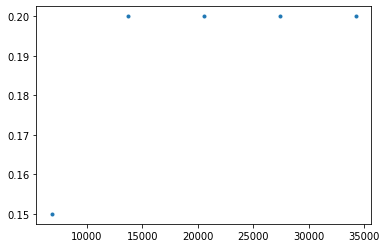

In [155]:
plt.plot(m2thrsh.keys(), m2thrsh.values(), '.')

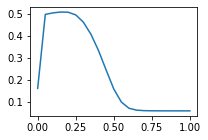

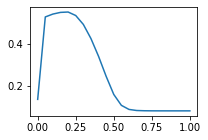

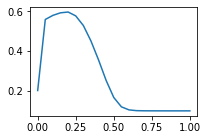

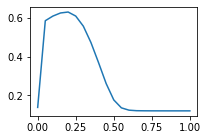

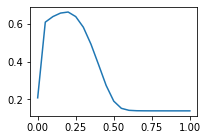

In [156]:
for m,res in m2res.items():
    plt.figure(figsize=(3,2))
    plt.plot(res['thrshes'], res['f1_lst'])  
    plt.show()

# fin

In [23]:
!nvidia-smi

Thu Apr  8 14:12:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   46C    P0    42W / 300W |   3096MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  